## Задача 1

Реализовать класс для работы с линейной регрессией

In [34]:
import pandas as pd
import numpy as np

class MyLinearRegression:
    """
    Parameters
    ----------
    regularization : {None, 'l1', 'l2', 'l1l2'}, default=None
        Какую регуляризацию добавить к модели. Если значение `None`, то без регуляризации.

    weight_calc : {'matrix', 'gd', 'sgd'}, default='matrix'
        Каким образом вычислять вектор весов: матрично ('matrix'), градиентным спуском ('gd') или стохастическим градиентным спуском ('sgd'). При этом, при 'l1' или 'l1l2' нельзя использовать параметр 'matrix'.

    Attributes
    ----------
    coefs_ : Вектор коэффициентов размера (p, 1), где p — количество признаков.
    intercept_ : Значение коэффициента, отвечающего за смещение
    """
    LEARNING_RATE = 0.01
    MAX_ITER = 5000
    TOL = 1e-6

    def __init__(self, regularization=None, weight_calc='matrix', lambda_1=None, lambda_2=None, batch_size=20):
        if regularization not in [None, 'l1', 'l2', 'l1l2']:
            raise TypeError(f"Параметр regularization не может принимать значение '{regularization}'")
        if weight_calc not in ['matrix', 'gd', 'sgd']:
            raise TypeError(f"Параметр weight_calc не может принимать значение '{weight_calc}'")
        if regularization in ['l1', 'l1l2'] and lambda_1 is None:
            raise TypeError(f"Значение коэффициента регулризации l1 не задано")
        if regularization in ['l2', 'l1l2'] and lambda_2 is None:
            raise TypeError(f"Значение коэффициента регулризации l2 не задано")

        self.regularization = regularization
        self.weight_calc = weight_calc
        self.lambda_1 = lambda_1 if lambda_1 is not None else 0.0
        self.lambda_2 = lambda_2 if lambda_2 is not None else 0.0
        self.batch_size = batch_size

        self.coefs_ = None
        self.intercept_ = None

    def _add_intercept(self, X: np.ndarray) -> np.ndarray:
        return np.column_stack([np.ones(X.shape[0]), X])

    def _mse_loss(self, y_true: np.ndarray, y_pred: np.ndarray) -> float:
        return np.mean((y_true - y_pred) ** 2)

    def _l1_penalty(self, w: np.ndarray) -> float:
        return self.lambda_1 * np.sum(np.abs(w[1:]))

    def _l2_penalty(self, w: np.ndarray) -> float:
        return self.lambda_2 * np.sum(w[1:] ** 2)

    def fit(self, X: pd.DataFrame, y: pd.DataFrame):
        X_np = X.to_numpy()
        y_np = y.to_numpy().ravel()

        X_with_intercept = self._add_intercept(X_np)

        if self.weight_calc == 'matrix':
            if self.regularization == 'l2':
                lambda_I = self.lambda_2 * np.eye(X_with_intercept.shape[1])
                lambda_I[0, 0] = 0
                weights = np.linalg.inv(X_with_intercept.T @ X_with_intercept + lambda_I) @ X_with_intercept.T @ y_np
            else:  # без регуляризации
                weights = np.linalg.inv(X_with_intercept.T @ X_with_intercept) @ X_with_intercept.T @ y_np

            self.intercept_ = weights[0]
            self.coefs_ = weights[1:].reshape(-1, 1)

        elif self.weight_calc in ['gd', 'sgd']:
            weights = np.zeros(X_with_intercept.shape[1])

            for iteration in range(self.MAX_ITER):
                if self.weight_calc == 'gd':
                    y_pred = X_with_intercept @ weights
                    gradients = X_with_intercept.T @ (y_pred - y_np) / len(y_np)
                else:  # sgd
                    indices = np.random.choice(len(y_np), self.batch_size, replace=False)
                    X_batch = X_with_intercept[indices]
                    y_batch = y_np[indices]
                    y_pred = X_batch @ weights
                    gradients = X_batch.T @ (y_pred - y_batch) / self.batch_size

                if self.regularization in ['l1', 'l1l2']:
                    l1_grad = self.lambda_1 * np.sign(weights)
                    l1_grad[0] = 0
                    gradients += l1_grad

                if self.regularization in ['l2', 'l1l2']:
                    l2_grad = 2 * self.lambda_2 * weights
                    l2_grad[0] = 0
                    gradients += l2_grad

                new_weights = weights - self.LEARNING_RATE * gradients

                if np.all(np.abs(new_weights - weights) < self.TOL):
                    weights = new_weights
                    break

                weights = new_weights

            self.intercept_ = weights[0]
            self.coefs_ = weights[1:].reshape(-1, 1)

    def predict(self, X: np.ndarray, ss=True) -> np.ndarray:
        if ss:
            X = np.array(X)
            return (X @ self.coefs_.ravel()) + self.intercept_
        else:
            X_with_int = self._add_intercept(X)
            return X_with_int @ np.concatenate([[self.intercept_], self.coefs_.ravel()])

    def score(self, X: np.ndarray, y: np.ndarray) -> float:
        y_pred = self.predict(X)
        y_mean = np.mean(y)
        ss_tot = np.sum((y - y_mean) ** 2)
        ss_res = np.sum((y - y_pred) ** 2)
        return 1 - ss_res / ss_tot if ss_tot != 0 else 0.0

Используя датасет про автомобили (целевой признак — price), сравнить (качество, скорость обучения и предсказания, важность признаков) модели `MyLinearRegression` с различными гиперпараметрами, сделать выводы. На этом же датасете сравнить модель `MyLinearRegression` с библиотечной реализацией из `sklearn`, составить таблицу(ы) (графики) результатов сравнения (качество, скорость обучения и предсказания, важность признаков).

In [35]:
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

df = pd.read_csv('Used_fiat_500_in_Italy_dataset.csv')

numeric_features = ['age_in_days', 'km', 'engine_power', 'previous_owners', 'lat', 'lon']
categorical_features = ['model', 'transmission']


df_processed = pd.get_dummies(df, columns=[c for c in categorical_features if c in df.columns], drop_first=True)

y = df_processed['price']
X = df_processed.drop(columns=['price'])

print(f"{X.shape[1]} признаков")

10 признаков



                                           ПОЛНОЕ СРАВНЕНИЕ МОДЕЛЕЙ                                           
                     Model      R²  Fit time (s)  Predict time (s)  Non-zero coefs
     MyLR (No reg, matrix) 0.89453       0.00074          0.000046              10
        MyLR (Ridge λ=0.1) 0.89452       0.00046          0.000030              10
        MyLR (Ridge λ=1.0) 0.89440       0.00046          0.000028              10
       MyLR (Ridge λ=10.0) 0.89267       0.00088          0.000068              10
       MyLR (Lasso λ=0.01) 0.89453       0.25283          0.000087              10
        MyLR (Lasso λ=0.1) 0.89451       0.25436          0.000049              10
        MyLR (Lasso λ=0.5) 0.89443       0.26891          0.000049              10
MyLR (ElasticNet 0.05+0.5) 0.74545       0.58743          0.000043              10
 MyLR (ElasticNet 0.2+1.0) 0.62782       0.59251          0.000043              10
  Sklearn LinearRegression 0.89453       0.00246          

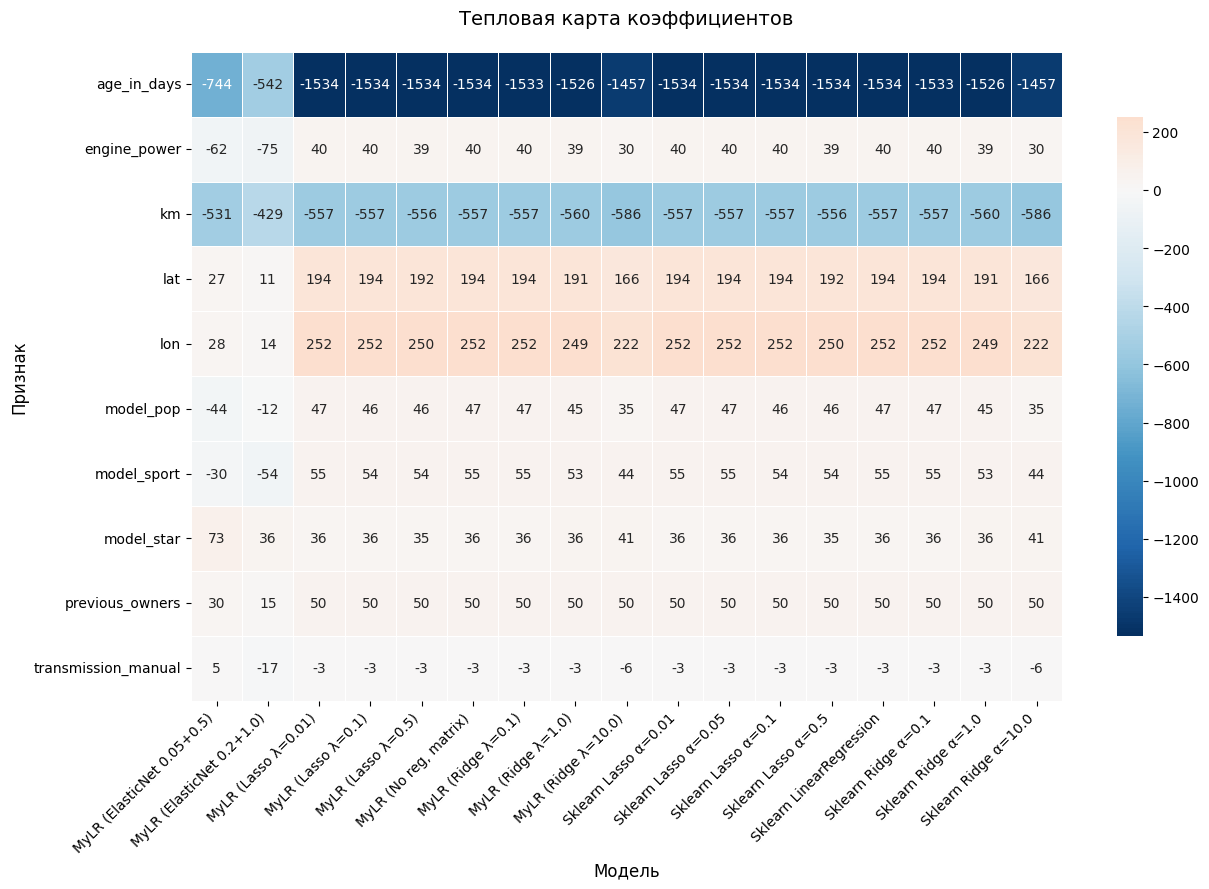


                                   ТОП ПРИЗНАКОВ ПО ВСЕМ МОДЕЛЯМ (среднее)                                    
age_in_days                          1418.91356
km                                   551.52566
lon                                  220.73594
lat                                  169.74087
model_sport                          51.57467
previous_owners                      46.92884
model_pop                            42.78932
engine_power                         41.74841
model_star                           38.56691
transmission_manual                   4.27569


In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

def get_coefs_df(model, feature_names, model_name):
    if hasattr(model, 'coefs_'):
        coefs = model.coefs_.ravel()
        intercept = model.intercept_
    else:
        coefs = model.coef_
        intercept = model.intercept_

    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefs,
        'Abs_Coefficient': np.abs(coefs)
    })
    coef_df = coef_df.sort_values('Abs_Coefficient', ascending=False).reset_index(drop=True)
    coef_df['Model'] = model_name
    coef_df['Intercept'] = intercept
    return coef_df

results = []
all_coefs = []

configs = [
    {"reg": None,     "calc": "matrix", "l1": None,   "l2": None,   "name": "MyLR (No reg, matrix)"},
    {"reg": "l2",     "calc": "matrix", "l1": None,   "l2": 0.1,    "name": "MyLR (Ridge λ=0.1)"},
    {"reg": "l2",     "calc": "matrix", "l1": None,   "l2": 1.0,    "name": "MyLR (Ridge λ=1.0)"},
    {"reg": "l2",     "calc": "matrix", "l1": None,   "l2": 10.0,   "name": "MyLR (Ridge λ=10.0)"},
    
    {"reg": "l1",     "calc": "gd",     "l1": 0.01,   "l2": None,   "name": "MyLR (Lasso λ=0.01)"},
    {"reg": "l1",     "calc": "gd",     "l1": 0.1,    "l2": None,   "name": "MyLR (Lasso λ=0.1)"},
    {"reg": "l1",     "calc": "gd",     "l1": 0.5,    "l2": None,   "name": "MyLR (Lasso λ=0.5)"},
    
    {"reg": "l1l2",   "calc": "sgd",    "l1": 0.05,   "l2": 0.5,    "name": "MyLR (ElasticNet 0.05+0.5)"},
    {"reg": "l1l2",   "calc": "sgd",    "l1": 0.2,    "l2": 1.0,    "name": "MyLR (ElasticNet 0.2+1.0)"},
]

sklearn_models = [
    ("Sklearn LinearRegression", LinearRegression()),
    
    ("Sklearn Ridge α=0.1",  Ridge(alpha=0.1)),
    ("Sklearn Ridge α=1.0",  Ridge(alpha=1.0)),
    ("Sklearn Ridge α=10.0", Ridge(alpha=10.0)),
    
    ("Sklearn Lasso α=0.01", Lasso(alpha=0.01, max_iter=30000, tol=1e-4)),
    ("Sklearn Lasso α=0.05", Lasso(alpha=0.05, max_iter=30000, tol=1e-4)),
    ("Sklearn Lasso α=0.1",  Lasso(alpha=0.1,  max_iter=30000, tol=1e-4)),
    ("Sklearn Lasso α=0.5",  Lasso(alpha=0.5,  max_iter=30000, tol=1e-4)),
]

for cfg in configs:
    model = MyLinearRegression(
        regularization=cfg["reg"],
        weight_calc=cfg["calc"],
        lambda_1=cfg["l1"],
        lambda_2=cfg["l2"],
        batch_size=32
    )
    
    start = time.time()
    model.fit(X_train_scaled, pd.DataFrame(y_train))
    fit_time = time.time() - start

    start = time.time()
    y_pred = model.predict(X_test_scaled.to_numpy())
    pred_time = time.time() - start

    r2 = r2_score(y_test, y_pred)
    non_zero = np.sum(np.abs(model.coefs_.ravel()) > 1e-10)

    results.append({
        "Model": cfg["name"],
        "R²": round(r2, 5),
        "Fit time (s)": round(fit_time, 5),
        "Predict time (s)": round(pred_time, 6),
        "Non-zero coefs": non_zero
    })

    coef_df = get_coefs_df(model, X_train_scaled.columns, cfg["name"])
    all_coefs.append(coef_df)


for name, model in sklearn_models:
    start = time.time()
    model.fit(X_train_scaled, y_train)
    fit_time = time.time() - start

    start = time.time()
    y_pred = model.predict(X_test_scaled)
    pred_time = time.time() - start

    r2 = r2_score(y_test, y_pred)
    non_zero = np.sum(np.abs(model.coef_) > 1e-10)

    results.append({
        "Model": name,
        "R²": round(r2, 5),
        "Fit time (s)": round(fit_time, 5),
        "Predict time (s)": round(pred_time, 6),
        "Non-zero coefs": non_zero
    })

    coef_df = get_coefs_df(model, X_train_scaled.columns, name)
    all_coefs.append(coef_df)

results_df = pd.DataFrame(results)
print("\n" + "="*110)
print("ПОЛНОЕ СРАВНЕНИЕ МОДЕЛЕЙ".center(110))
print("="*110)
print(results_df.to_string(index=False))

full_coefs = pd.concat(all_coefs)

plt.figure(figsize=(13, 9))
top_features = full_coefs.groupby('Feature')['Abs_Coefficient'].mean().sort_values(ascending=False).head(12).index

plot_data = full_coefs[full_coefs['Feature'].isin(top_features)]
plot_data = plot_data.pivot(index='Feature', columns='Model', values='Coefficient')

sns.heatmap(plot_data, annot=True, cmap="RdBu_r", center=0, fmt=".0f", linewidths=.5, cbar_kws={'shrink': 0.8})
plt.title("Тепловая карта коэффициентов", fontsize=14, pad=20)
plt.ylabel("Признак", fontsize=12)
plt.xlabel("Модель", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("\n" + "="*110)
print("ТОП ПРИЗНАКОВ ПО ВСЕМ МОДЕЛЯМ (среднее)".center(110))
print("="*110)
top10_avg = full_coefs.groupby('Feature')['Abs_Coefficient'].mean().sort_values(ascending=False).head(10)
for feat, val in top10_avg.items():
    print(f"{feat:<35}  {val:8.5f}")

## Вывод

### Качество предсказания
Все модели без сильной регуляризации показывают отличный результат:  
$R^2$ ≈ 0.894–0.895 на тестовом наборе.  
Это означает, что линейная регрессия объясняет почти 90 % разброса цен.


### Корректность собственной реализации
Реализация `MyLinearRegression` с матричным методом, градиентным спуском и L2-регуляризацией работает не хуже, чем библиотечные `LinearRegression` и `Ridge` из sklearn.  
Разница в $R^2$ минимальна (≈0.00001).


### L1 и ElasticNet не обнуляют коэффициенты
При использовании **Lasso** и **ElasticNet** с умеренными λ все 10 признаков остаются в модели. 

- После предобработки в датасете осталось всего 10 признаков, и все они действительно влияют на цену.  
- Самые важные признаки:
  - age_in_days (возраст машины) -- ~1417 за год
  - km (пробег) -- ~550 за 1000 км 
  - lon и lat (географические координаты,региональные различия цен) 
  - model_sport, model_pop, engine_power и другие  

Даже агрессивная L1-регуляризация слегка уменьшает веса, но не обнуляет их, так как все признаки полезны.


### Проблемы с ElasticNet
При сильной комбинации L1+L2 ($λ_1$=0.2 и $λ_2$=1.0) качество падает: $R^2$ ≈ 0.598.  
Причина -- градиентный спуск не успевает сойтись при больших штрафах и фиксированном шаге обучения.  



### Скорость обучения
- Матричное решение -- самое быстрое 
- GD-реализация Lasso -- ~0.25 с (гораздо медленнее sklearn)  
- sklearn Lasso -- ~0.003 с благодаря координатному спуску  
- Предсказания у всех моделей происходят почти мгновенно


## Задача 2

[Соревнование на Kaggle](https://kaggle.com/competitions/yadro-regression-2025)